In [1]:
setwd('/import/DB/fel/BJTC-204')

In [3]:
library(dplyr)

In [4]:
load('combat_edata.rda')

In [5]:
ls()

[1] "anno"          "combat_edata1"

In [18]:
dim(combat_edata1)

[1] 17595   106

In [6]:
head(combat_edata1,2)

,V35,V36,V37,V40,V45,V47,V49,V53,V57,V10,...,SL7403,SL7404,SL7614,SL7625,SL7632,SL7698,SL7801,SL7804,SL7806,SL7807
TSPAN6,4.8855924,5.592884,3.4428496,3.7363912,5.9165153,2.1528251,10.3872316,6.00692072,6.4434011,7.1091159,...,5.6749662,5.8173691,6.8984423,7.621011470,5.0385645,4.9958755,4.0209414,4.2321834,5.437145,2.8780995
TNMD,0.4916594,1.086108,0.3092027,0.3842629,0.4610154,0.2135806,0.7058792,0.04530282,0.5785653,0.4157408,...,0.5208888,0.4394116,0.6898495,0.008500946,0.2940237,0.4711074,0.1781892,0.1892436,0.550114,0.4405159


In [10]:
colnames(anno)

[1] "group"  "Matrix"

In [13]:
control.group = anno %>% tibble::rownames_to_column(.,'sample') %>% dplyr::select(sample,group) %>% 
tibble::remove_rownames() %>%   tibble::column_to_rownames(.,'sample')

In [15]:
library(dplyr)

In [16]:
group.all1 = control.group

In [17]:
head(group.all1,6)

,group
,<chr>
V35,MDD
V36,MDD
V37,MDD
V40,MDD
V45,MDD
V47,MDD


In [35]:
dataExpr = combat_edata1

In [36]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
#exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Allowing parallel execution with up to 255 working processes.


In [37]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.25)),]
dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [38]:
dim(dataExpr)

[1]   106 13196

In [39]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}


In [40]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]   106 13196

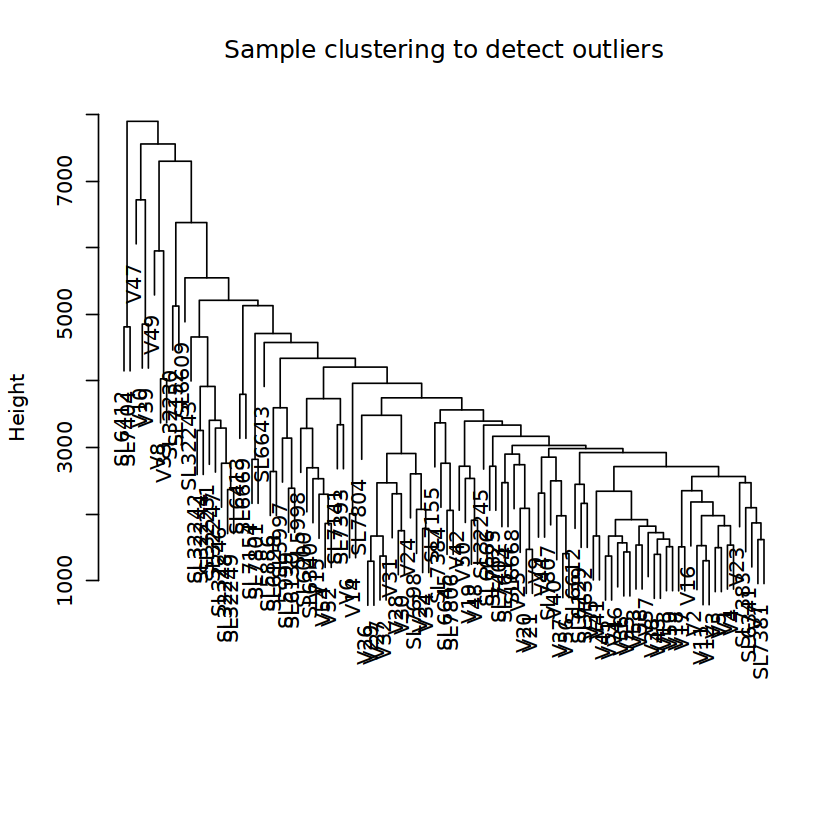

In [42]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [43]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 3390.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3390 of 13196
   ..working on genes 3391 through 6780 of 13196
   ..working on genes 6781 through 10170 of 13196
   ..working on genes 10171 through 13196 of 13196
   Power SFT.R.sq  slope truncated.R.sq  mean.k. median.k. max.k.
1      1   0.7130  2.830          0.965 3230.000  3.22e+03 4810.0
2      2   0.0187  0.188          0.853 1240.000  1.17e+03 2580.0
3      3   0.3050 -0.771          0.873  588.000  5.20e+02 1620.0
4      4   0.5900 -1.120          0.943  319.000  2.64e+02 1100.0
5      5   0.7130 -1.420          0.941  189.000  1.47e+02  809.0
6      6   0.7880 -1.590          0.957  119.000  8.56e+01  618.0
7      7   0.8070 -1.700          0.955   79.100  5.23e+01  484.0
8      8   0.8340 -1.760          0.963   54.400  3.28e+01  386.0
9      9   0.8510 -1.800          0.969   38.500  2.09e+01  313.0
10    10   0.8720 -1.810          

In [44]:
options(repr.plot.width = 9)

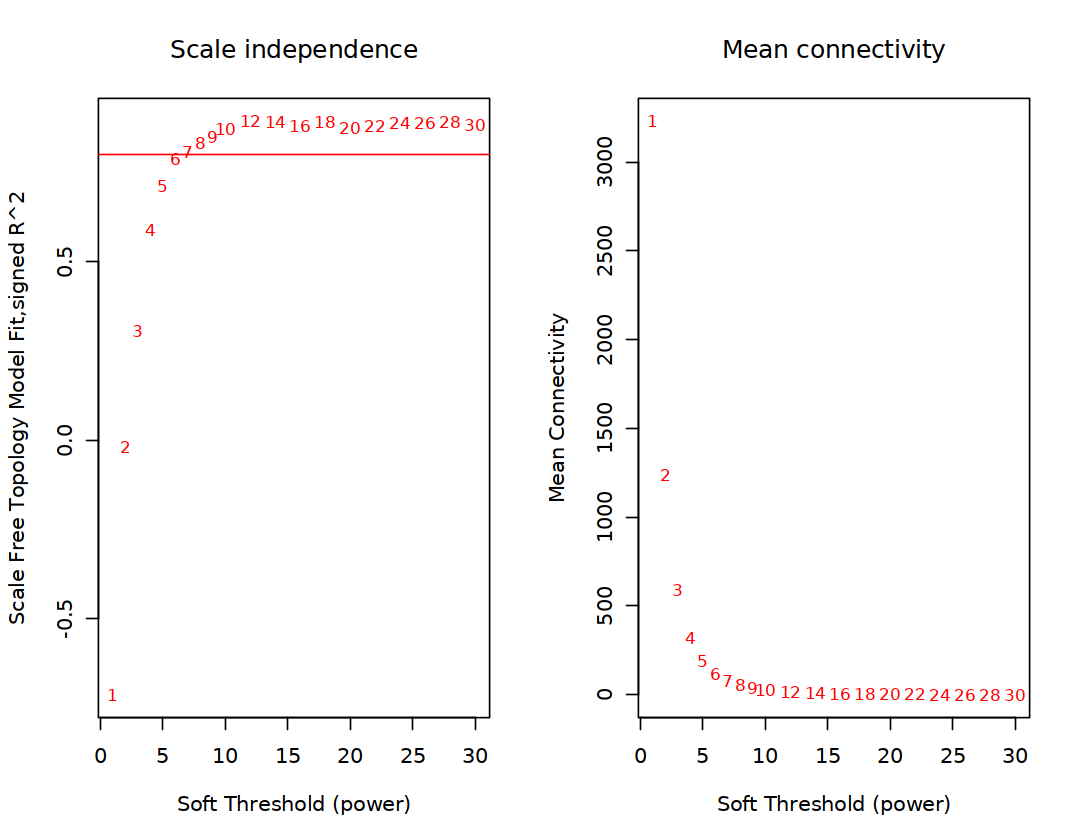

In [45]:
par(mfrow = c(1,2))
cex1 = 0.8
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.8,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [48]:
power = sft$powerEstimate
power

[1] 9

In [49]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [50]:
exprMat='data.txt'

In [51]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 50,
                       reassignThreshold = 0, mergeCutHeight = 0.35,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file data.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 1 genes from module 2 because their KME is too low.
     ..removing 7 genes from module 3 because their KME is too low.
     ..removing 1 genes from module 4 because their KME is too low.
     ..removing 2 genes from module 7 because their KME is too low.
     ..removing 1 genes from module 18 because their KME is too low.
     ..removing 1 genes from module 22 because their KME is too low.
 ..merging modules that are too close..
    

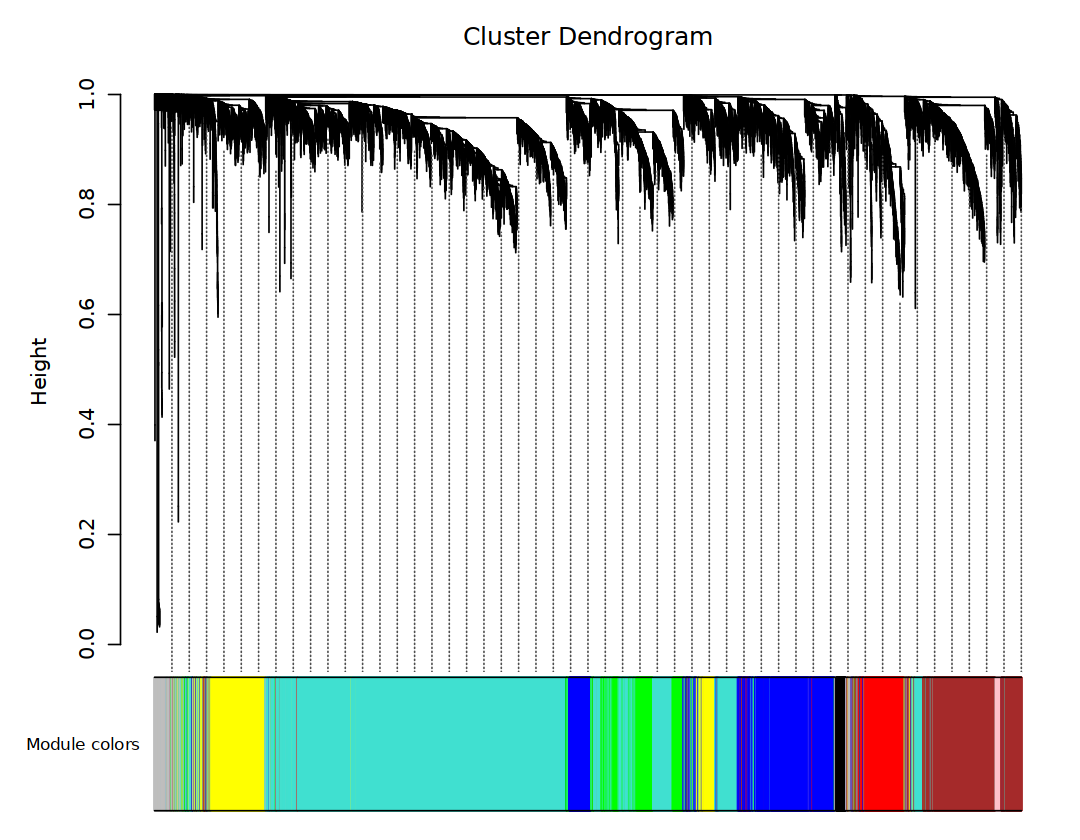

In [52]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [53]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

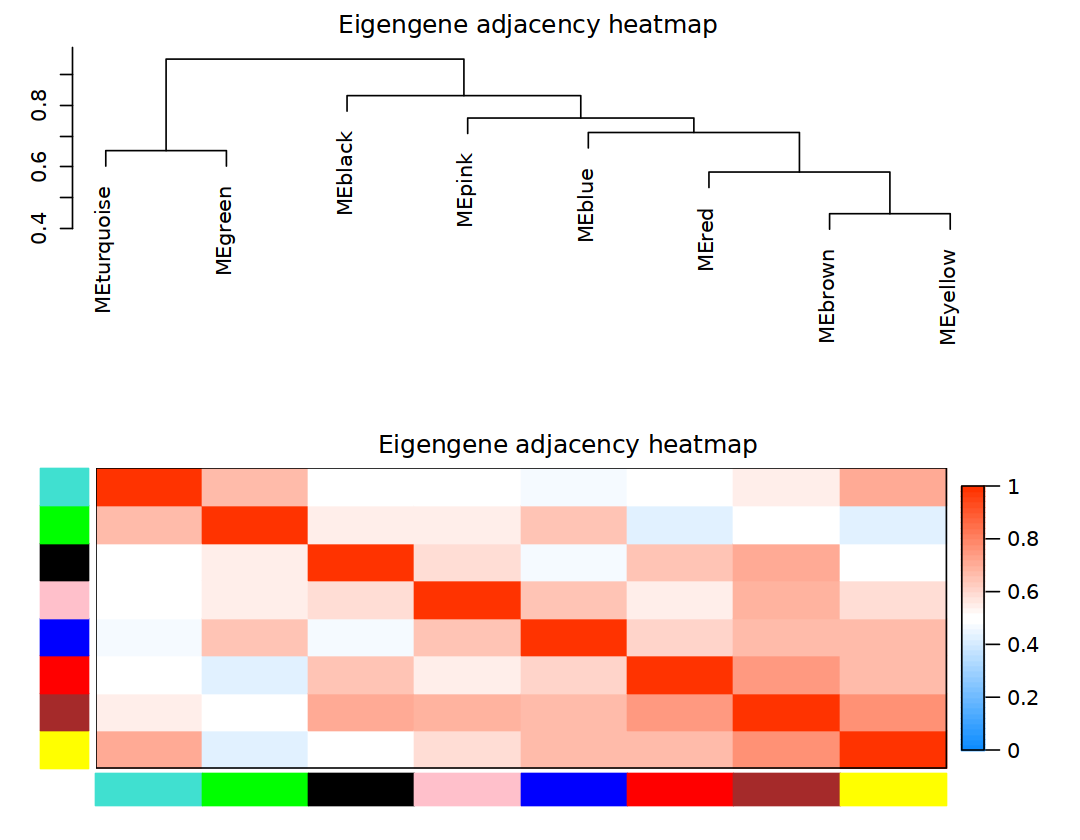

In [54]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [83]:
#TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

In [56]:
group.all1  = group.all1 %>%  tibble::rownames_to_column(.,'sample')

In [57]:
colnames(group.all1)[2] = 'group'

In [58]:
group.all1$group = as.character(group.all1$group )

In [59]:
design <- model.matrix(~0 + group.all1$group)


In [60]:
dimnames(design) <- list(group.all1$sample, sort(unique(group.all1$group)))


In [61]:

design <- design[rownames(MEs_col),]
# 计算 pearson 相关性和显著性
modTraitCor <- cor(MEs_col, design, use = "p")
modTraitP <- corPvalueStudent(modTraitCor, dim(group.all1)[1])

In [62]:
modTraitCorP = bicorAndPvalue(MEs_col, design)
modTraitCor = modTraitCorP$bicor
modTraitP   = modTraitCorP$p

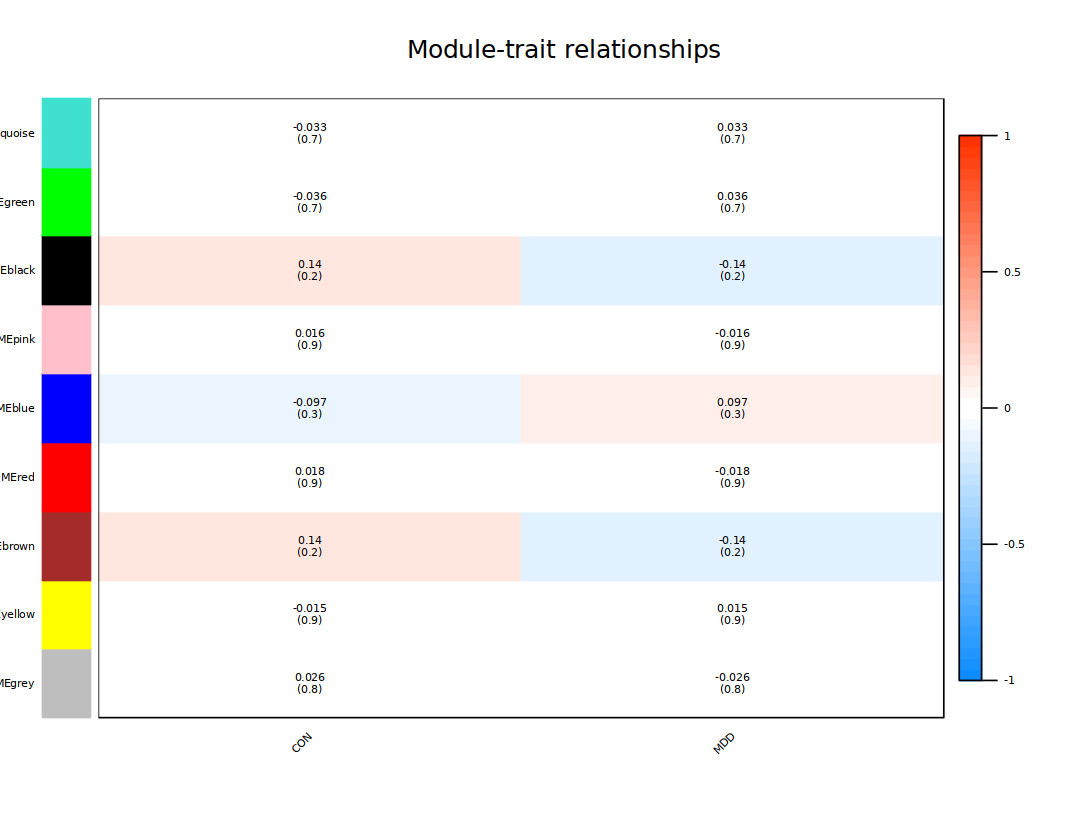

In [63]:
textMatrix <- paste0(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")")
dim(textMatrix) <- dim(modTraitCor)
labeledHeatmap(
  Matrix = modTraitCor,
  xLabels = colnames(design),
  yLabels = colnames(MEs_col),
  cex.lab = 0.5,
  ySymbols = colnames(MEs_col),
  colorLabels = FALSE,
  colors = blueWhiteRed(50),
  textMatrix = textMatrix,
  setStdMargins = FALSE,
  cex.text = 0.5,
  zlim = c(-1, 1),
  main = paste("Module-trait relationships")
)

In [ ]:
dat = dataExpr

In [ ]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, design, use = "p")) 

In [ ]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(design), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(design), sep="")

In [ ]:
module <- "yellow"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

In [ ]:
verboseScatterplot(
  MM, GS,
  xlab = paste("Module Membership in", module, "module"),
  ylab = "Gene significance for proliferating",
  main = paste("Module membership vs. gene significance\n"),
  abline = TRUE,
  pch = 21,
  cex.main = 1.2,
  cex.lab = 1.2,
  cex.axis = 1.2,
  col = "black",
  bg = module
)

In [ ]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.3,v=0.8,col="red",lwd=1.5)

In [ ]:
brown_hub <- brown_moduleGenes[(GS > 0.3 & MM > 0.8)]
length(brown_hub)

In [ ]:
write.csv(brown_hub,'brown_hub_gene.csv')

In [ ]:
library(clusterProfiler)
library(org.Hs.eg.db)
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Hs.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")


In [ ]:
table(is.na(sig_DP_entrezId))

In [ ]:

sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Hs.eg.db,
                      keyType = "ENTREZID",
                      ont = "ALL",
                      pvalueCutoff = 0.05,
                      qvalueCutoff = 1,
                      readable = TRUE)


In [ ]:
#画图
dotplot(go_bp)

In [ ]:
ek <- enrichKEGG(gene =sig_DP_entrezId , 
                   organism = "hsa",  
                   pvalueCutoff =1, 
                   qvalueCutoff = 1) 
    keggres = ek@result
    #write.csv(keggres,file = 'kegg_results.csv')
    enrichplot::dotplot(ek,  
            x = "GeneRatio", 
            color = "p.adjust", 
            showCategory = 15, 
            size = 'Count', 
            title = "KEGG_enrichment_dotplot"  
            )
    #ggsave('KEGG_enrichment_dotplot.pdf',height = 6,width = 6)
    KEGG2 <- pairwise_termsim(ek)
    emapplot(KEGG2, cex_label_category=.8, cex_line=.5,showCategory = 15) + 
      ggplot2::scale_fill_continuous(low = "#e06663", high = "#327eba", name = "p.adjust",
                            guide = ggplot2::guide_colorbar(reverse = TRUE, order=2.5), trans='log10')
    #ggsave('KEGG_enrichment_net.pdf',height = 8,width = 8)   